# Processing your Data with topsApp.py

**Author**: Bekaert David, Heresh Fattahi, Piyush Agram

In this notebook, we will walk through the various steps of processing with topsApp.py. 

topsApp.py is a pair-by-pair interferometric processor that takes as input two Sentinel-1 SAR acquisitions acquired in TOPS mode. topsApp.py will not work for other Sentinel-1 acquisition formats such as Stripmap. ISCE's stripmapApp.py supports interferometric stripmap processing of Sentinel-1 and other sensors. At this time, topsApp only supports SLC data from Sentinel-1 A and B. Processing is supported across the Sentinel-1 constellation, i.e. data acquired from A and B can be combined.

To illustrate the usage of topsApp.py, we will use a Sentinel-1 dataset capturing the surface deformation as result of the 15 May 2020 Mw6.5 Monte Cristo Range Earthquake that occurred in Nevada [(details here)](https://en.wikipedia.org/wiki/2020_Nevada_earthquake). The exercise runs the workflow step by step to generate a geocoded interferogram. 

## 0. Initial setup of the notebook

This notebooks uses the following directory structure

```
.
├── topsApp.ipynb     (This notebook)
├── insar             (This is where we will process the interferogram)
├── support_docs      (Figures used in this notebook)
└── data              (This is where we will download data for this notebook)
```

The cell below performs initial setup of the notebook and must be run every time the notebook is used. It is possible to partially complete the exercise, close the notebook, and come back and continue later from that point, but this initialization must be re-run before restarting (as well as Step 1.2.1 if the slc download step 1.2 is skipped).  Initialization defines the processing locations as well as a few plotting routines that will be used throughout the tutorial, and this information is lost when the notebook is closed.

In [1]:
from shutil import copyfile, move # Utilities for copying and moving files
from osgeo import gdal            # GDAL support for reading virtual files
import os                         # To create and remove directories
import matplotlib.pyplot as plt   # For plotting
import numpy as np                # Matrix calculations
import glob                       # Retrieving list of files
import boto3                      # For talking to s3 bucket

# directory in which the notebook resides
if 'tutorial_home_dir' not in globals():
    tutorial_home_dir = os.getcwd()
print("Notebook directory: ", tutorial_home_dir)

# directory for data downloads
slc_dir = os.path.join(tutorial_home_dir,'data', 'slcs')
orbit_dir = os.path.join(tutorial_home_dir, 'data', 'orbits')
insar_dir = os.path.join(tutorial_home_dir, 'insar')


# defining backup dirs in case of download issues on the local server
s3 = boto3.resource("s3")
data_backup_bucket = s3.Bucket("asf-jupyter-data")
data_backup_dir = "TOPS"

# generate all the folders in case they do not exist yet
os.makedirs(slc_dir, exist_ok=True)
os.makedirs(orbit_dir, exist_ok=True)
os.makedirs(insar_dir, exist_ok=True)

# Always start at the notebook directory    
os.chdir(tutorial_home_dir)


# Utility to copy data from 
def copy_from_bucket(file_in_bucket, dest_file,
                    bucket=data_backup_bucket):
    if os.path.exists(dest_file):
        print("Destination file {0} already exists. Skipping download...".format(dest_file))
    else:
        bucket.download_file(file_in_bucket, dest_file)

# Utility to plot a 2D array
def plotdata(GDALfilename, band=1,
             title=None,colormap='gray',
             aspect=1, background=None,
             datamin=None, datamax=None,
             interpolation='nearest',
             nodata = None,
             draw_colorbar=True, colorbar_orientation="horizontal"):
    
    # Read the data into an array
    ds = gdal.Open(GDALfilename, gdal.GA_ReadOnly)
    data = ds.GetRasterBand(band).ReadAsArray()
    transform = ds.GetGeoTransform()
    ds = None
    
    try:
        if nodata is not None:
            data[data == nodata] = np.nan
    except:
        pass
        
    # getting the min max of the axes
    firstx = transform[0]
    firsty = transform[3]
    deltay = transform[5]
    deltax = transform[1]
    lastx = firstx+data.shape[1]*deltax
    lasty = firsty+data.shape[0]*deltay
    ymin = np.min([lasty,firsty])
    ymax = np.max([lasty,firsty])
    xmin = np.min([lastx,firstx])
    xmax = np.max([lastx,firstx])

    # put all zero values to nan and do not plot nan
    if background is None:
        try:
            data[data==0]=np.nan
        except:
            pass
    
    fig = plt.figure(figsize=(18, 16))
    ax = fig.add_subplot(111)
    cax = ax.imshow(data, vmin = datamin, vmax=datamax,
                    cmap=colormap, extent=[xmin,xmax,ymin,ymax],
                    interpolation=interpolation)
    ax.set_title(title)
    if draw_colorbar is not None:
        cbar = fig.colorbar(cax,orientation=colorbar_orientation)
    ax.set_aspect(aspect)    
    plt.show()
    
    # clearing the data
    data = None

# Utility to plot interferograms
def plotcomplexdata(GDALfilename,
                    title=None, aspect=1,
                    datamin=None, datamax=None,
                    interpolation='nearest',
                    draw_colorbar=None, colorbar_orientation="horizontal"):
    # Load the data into numpy array
    ds = gdal.Open(GDALfilename, gdal.GA_ReadOnly)
    slc = ds.GetRasterBand(1).ReadAsArray()
    transform = ds.GetGeoTransform()
    ds = None
    
    # getting the min max of the axes
    firstx = transform[0]
    firsty = transform[3]
    deltay = transform[5]
    deltax = transform[1]
    lastx = firstx+slc.shape[1]*deltax
    lasty = firsty+slc.shape[0]*deltay
    ymin = np.min([lasty,firsty])
    ymax = np.max([lasty,firsty])
    xmin = np.min([lastx,firstx])
    xmax = np.max([lastx,firstx])

    # put all zero values to nan and do not plot nan
    try:
        slc[slc==0]=np.nan
    except:
        pass

    
    fig = plt.figure(figsize=(18, 16))
    ax = fig.add_subplot(1,2,1)
    cax1=ax.imshow(np.abs(slc), vmin = datamin, vmax=datamax,
                   cmap='gray', extent=[xmin,xmax,ymin,ymax],
                   interpolation=interpolation)
    ax.set_title(title + " (amplitude)")
    if draw_colorbar is not None:
        cbar1 = fig.colorbar(cax1,orientation=colorbar_orientation)
    ax.set_aspect(aspect)

    ax = fig.add_subplot(1,2,2)
    cax2 =ax.imshow(np.angle(slc), cmap='rainbow',
                    vmin=-np.pi, vmax=np.pi,
                    extent=[xmin,xmax,ymin,ymax],
                    interpolation=interpolation)
    ax.set_title(title + " (phase [rad])")
    if draw_colorbar is not None:
        cbar2 = fig.colorbar(cax2, orientation=colorbar_orientation)
    ax.set_aspect(aspect)
    plt.show()
    
    # clearing the data
    slc = None

# Utility to plot multiple similar arrays
def plotstackdata(GDALfilename_wildcard, band=1,
                  title=None, colormap='gray',
                  aspect=1, datamin=None, datamax=None,
                  interpolation='nearest',
                  draw_colorbar=True, colorbar_orientation="horizontal"):
    # get a list of all files matching the filename wildcard criteria
    GDALfilenames = glob.glob(GDALfilename_wildcard)
    
    # initialize empty numpy array
    data = None
    for GDALfilename in GDALfilenames:
        ds = gdal.Open(GDALfilename, gdal.GA_ReadOnly)
        data_temp = ds.GetRasterBand(band).ReadAsArray()   
        ds = None
        
        if data is None:
            data = data_temp
        else:
            data = np.vstack((data,data_temp))

    # put all zero values to nan and do not plot nan
    try:
        data[data==0]=np.nan
    except:
        pass            
            
    fig = plt.figure(figsize=(18, 16))
    ax = fig.add_subplot(111)
    cax = ax.imshow(data, vmin = datamin, vmax=datamax,
                    cmap=colormap, interpolation=interpolation)
    ax.set_title(title)
    if draw_colorbar is not None:
        cbar = fig.colorbar(cax,orientation=colorbar_orientation)
    ax.set_aspect(aspect)    
    plt.show() 

    # clearing the data
    data = None

# Utility to plot multiple simple complex arrays
def plotstackcomplexdata(GDALfilename_wildcard,
                         title=None, aspect=1,
                         datamin=None, datamax=None,
                         interpolation='nearest',
                         draw_colorbar=True, colorbar_orientation="horizontal"):
    # get a list of all files matching the filename wildcard criteria
    GDALfilenames = glob.glob(GDALfilename_wildcard)
    print(GDALfilenames)
    # initialize empty numpy array
    data = None
    for GDALfilename in GDALfilenames:
        ds = gdal.Open(GDALfilename, gdal.GA_ReadOnly)
        data_temp = ds.GetRasterBand(1).ReadAsArray()
        ds = None
        
        if data is None:
            data = data_temp
        else:
            data = np.vstack((data,data_temp))

    # put all zero values to nan and do not plot nan
    try:
        data[data==0]=np.nan
    except:
        pass              
            
    fig = plt.figure(figsize=(18, 16))
    ax = fig.add_subplot(1,2,1)
    cax1=ax.imshow(np.abs(data), vmin=datamin, vmax=datamax,
                   cmap='gray', interpolation='nearest')
    ax.set_title(title + " (amplitude)")
    if draw_colorbar is not None:
        cbar1 = fig.colorbar(cax1,orientation=colorbar_orientation)
    ax.set_aspect(aspect)

    ax = fig.add_subplot(1,2,2)
    cax2 =ax.imshow(np.angle(data), cmap='rainbow',
                            interpolation='nearest')
    ax.set_title(title + " (phase [rad])")
    if draw_colorbar is not None:
        cbar2 = fig.colorbar(cax2,orientation=colorbar_orientation)
    ax.set_aspect(aspect)
    plt.show() 
    
    # clearing the data
    data = None

Notebook directory:  /home/jovyan/nisar-on-demand-use-cases


## 1. Overview of the tutorial input dataset

Let us first take a look at the dataset. For our dataset we are focusing on Descending track 71 and acquisitions dates of 2020-05-11 and 2020-05-17. 

More information on the event can be found on USGS's Monte Cristo Range Earthquake page [here](https://earthquake.usgs.gov/earthquakes/eventpage/nn00725272/executive) 

You can see the scenes of interest on ASF's Vertex page [here](https://search.asf.alaska.edu/#/?zoom=6.9117542264702365&center=-117.963049,38.048229&polygon=POLYGON((-118.2093%2038.0347,-117.6875%2038.0347,-117.6875%2038.3268,-118.2093%2038.3268,-118.2093%2038.0347))&path=71-71&start=2020-05-11T00:00:00Z&end=2020-05-17T23:59:00Z&productTypes=SLC&resultsLoaded=true)

The area of interest is captured by a single SLC on each pass and we shall use those in this tutorial. Even, if the event were to occur at an image boundary - all one would need to do is to download the multiple SLCs on the same track and topsApp.py will process and mosaic them for you.

**<font color="blue">Note:<br>**
    This earthquake was really well imaged on multiple tracks and with 6-day temporal sampling. If interested, feel free to process the other tracks - 64 and 144. We encourage students to do this to understand the impact of imaging geometry and projection of deformation in line-of-sight direction</font>

### 1.1 Background on TOPS mode

The TOPS acquisition strategy is different than conventional stripmap mode. TOPS stands for Terrain Observation with Progressive Scans. As the name indicates, the radar sensor performs a scan of the surface by electronically steering the antenna beam from a backward-pointing along-track direction to a forward-pointing along-track direction for a fixed range swath (also called a subswath).
![title](support_docs/tops_mode.png)
After a successful scan at that range extent, the antenna beam is electronically rolled back to its initial position, the range swath is electronically directed outward to a new area to increase coverage, and the next scan is made from backward to forward along track at this new range swath. After a third scan at a third range swath, the entire process is repeated over and over to create a continuous image as the satellite flies along.  The timing of the scans is such that there is a small geographic overlap between successive scans at a given range to ensure continuous coverage. Each scan at a given range swath is known as a "burst".  When inspecting one of the downloaded SLC products you will note that data are provided in 3 individual subswaths (IW1, IW2, IW3) each with a set of bursts. All together they form a Sentinel-1 frame, typically ~250 x 250 km in size. The bursts are approximately 20 km in length and overlap by 2 km. Due to the TOPS acquisition mode, the overlap region in successive bursts is seen from two different directions (forward looking and backward looking).
![title](support_docs/tops.png)
The ESA website provides detailed background information on Sentinel-1 products and technical information of the TOPS sensors. Whenever during the tutorial you are waiting for the processing to complete, you could explore their webpage at https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar

### 1.2 SLC download

The ASF vertex page (https://www.asf.alaska.edu/sentinel/) and the SSARA GUI (http://web-services.unavco.org/brokered/ssara/gui) both offer a GUI to visually search for available Sentinel-1 data over your area of interest. Once you have found your data, you can download it from the GUI. ASF provides a bulk-download python script.

Alternatively, you can use SSARA from command line.

In [2]:
!git clone https://github.com/bakerunavco/SSARA.git  

Cloning into 'SSARA'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 219 (delta 2), reused 8 (delta 1), pack-reused 210
Receiving objects: 100% (219/219), 1.22 MiB | 2.22 MiB/s, done.
Resolving deltas: 100% (103/103), done.


Running the client without any options will print the help message and describe the options.  Some usage examples are given in the help as well. 

In [3]:
!SSARA/ssara_federated_query.py  

Usage: ssara_federated_query.py [options]

Command line client for searching with the SSARA Federated API, 
creating KMLs, and downloading data.  See the options and 
descriptions below for details and usage examples.

For questions or comments, contact Scott Baker: baker@unavco.org
    
Options:
  --version             show program's version number and exit
  -h, --help            show this help message and exit

  Query Parameters:
    These options are used for the API query.  Use options to limit what
    is returned by the search. These options act as a way to filter the
    results and narrow down the search results.

    -p <ARG>, --platform=<ARG>
                        List of platforms (ie ALOS, ENVISAT, ERS-2...
    -a <ARG>, --absoluteOrbit=<ARG>
                        Absolute orbit (single orbit or list)
    -r <ARG>, --relativeOrbit=<ARG>
                        Relative Orbit (ie track or path)
    -i <ARG>, --intersectsWith=<ARG>
                        WKT format POI

Take some time to perform some example searches in a terminal window to get a feel from how the client works.
<br>
<div class="alert alert-warning">
<b>TIP:</b> 
In case you are not sure about some of the SSARA API fields (e.g. the platform name, the polygon etc.), you can experiment with the SSARA GUI first. One potential solution is to draw a polygon without specifying much additional information, see what the search table returns for keywords, and use those on the command line API. 
</div>

The following command provides the necessary filters for the search and returns the two scenes we need for processing:

In [4]:
!SSARA/ssara_federated_query.py --platform=sentinel-1B,sentinel-1A \
--relativeOrbit=71 -s 2020-05-11 -e 2020-05-18 \
--intersectsWith='POLYGON((-118.2093 38.0347,-117.6875 38.0347,-117.6875 38.3268,-118.2093 38.3268,-118.2093 38.0347))'\
--print


Running SSARA API Query:  https://web-services.unavco.org/brokered/ssara/api/sar/search?platform=sentinel-1B%2Csentinel-1A&relativeOrbit=71&start=2020-05-11&end=2020-05-18&processingLevel=L0%2CL1.0%2CSLC&intersectsWith=POLYGON%28%28-118.2093+38.0347%2C-117.6875+38.0347%2C-117.6875+38.3268%2C-118.2093+38.3268%2C-118.2093+38.0347%29%29
SSARA API query: 5.301189 seconds
Found 2 scenes
wget -O dem.tif "http://ot-data1.sdsc.edu:9090/otr/getdem?north=39.852557&south=36.983995&east=-114.971208&west=-118.624800&demtype=SRTMGL1_E"
gdal_translate -of GMT -ot Int16 -projwin -118.624800 39.852557 -114.971208 36.983995 /vsicurl/https://cloud.sdsc.edu/v1/AUTH_opentopography/Raster/SRTM_GL1_Ellip/SRTM_GL1_Ellip_srtm.vrt dem.grd
ASF,Sentinel-1A,32518,2020-05-11T13:51:17.000000,2020-05-11T13:51:44.000000,71,2821,2821,IW,None,DESCENDING,R,VV+VH,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_SLC__1SDV_20200511T135117_20200511T135144_032518_03C421_7768.zip
ASF,Sentinel-1B,21622,2020-05-17T13:50:26.000000,2

By changing the **--print** to **--download** you can download the files once you set up your password and username for SSARA in the **password_config.py** file.

Below we include a small python script to download the data which allows you to directly parse your pasword and username at the top of the function (this will take a few minutes for each file).

In [8]:
# Update this with your NASA Earthdata login to download SLC data
# Earthdata login is in the .netrc file
# ASF_USER = "foo"
# ASF_PASS = "bar"

files = ['https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_SLC__1SDV_20200511T135117_20200511T135144_032518_03C421_7768.zip',
         'https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_SLC__1SDV_20200517T135026_20200517T135056_021622_0290CB_99E2.zip']
         
# if len(ASF_USER)==0 or len(ASF_PASS)==0:
    # raise Exception("Specifiy your ASF password and user (earthdata log-in)")
    
for file in files:
    filename = os.path.basename(file)
    
    if not os.path.exists(os.path.join(slc_dir,filename)):
        # cmd = "wget {0} --user={1} --password={2} -P {3} -nc".format(file, ASF_USER, ASF_PASS, slc_dir)
        cmd = "wget {0} -P {1} -nc".format(file, slc_dir)
        print(cmd)
        os.system(cmd)
    else:
        print(filename + " already exists. Skipping download ..")

wget https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_SLC__1SDV_20200511T135117_20200511T135144_032518_03C421_7768.zip -P /home/jovyan/nisar-on-demand-use-cases/data/slcs -nc
wget https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_SLC__1SDV_20200517T135026_20200517T135056_021622_0290CB_99E2.zip -P /home/jovyan/nisar-on-demand-use-cases/data/slcs -nc


Files size are 4+GB each.

In [9]:
! ls -lh {slc_dir}

total 8.7G
-rw-r--r-- 1 jovyan users 4.2G May 11 17:40 S1A_IW_SLC__1SDV_20200511T135117_20200511T135144_032518_03C421_7768.zip
-rw-r--r-- 1 jovyan users 4.6G May 18 04:28 S1B_IW_SLC__1SDV_20200517T135026_20200517T135056_021622_0290CB_99E2.zip


#### 1.2.1 Download issues

In case the download does not work, we have pre-downloaded the required files. Run the routine below to copy these files into your work directory.

In [10]:
files = ['https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_SLC__1SDV_20200511T135117_20200511T135144_032518_03C421_7768.zip',
         'https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_SLC__1SDV_20200517T135026_20200517T135056_021622_0290CB_99E2.zip']
         
for file in files:
    filename = os.path.basename(file)  
    localfilename = os.path.join(slc_dir, filename)
    if not os.path.exists(localfilename):  
        copy_from_bucket(os.path.join("TOPS", filename),
                        localfilename)
    else:
        print(filename + " already exists")

S1A_IW_SLC__1SDV_20200511T135117_20200511T135144_032518_03C421_7768.zip already exists
S1B_IW_SLC__1SDV_20200517T135026_20200517T135056_021622_0290CB_99E2.zip already exists


File sizes are around 4+ GB each

#### 1.2.2 Set/Reset to home directory

This step is required each time the notebook is restarted and the slc download is skipped.  It can also be run in the initial run, though it is not needed since the directory is reset during the slc download process.

In [11]:
os.chdir(tutorial_home_dir)

In [12]:
!ls -lh {slc_dir}

total 8.7G
-rw-r--r-- 1 jovyan users 4.2G May 11 17:40 S1A_IW_SLC__1SDV_20200511T135117_20200511T135144_032518_03C421_7768.zip
-rw-r--r-- 1 jovyan users 4.6G May 18 04:28 S1B_IW_SLC__1SDV_20200517T135026_20200517T135056_021622_0290CB_99E2.zip


### 1.3 SLC filenaming convention

TOPS SLC product files delivered from ESA are zip archives. When unpacked the zip extension will be replaced by SAFE. The products are therefore also frequently called SAFE files. topsApp.py can read the data from either a zip file or a SAFE file. To limit disk usage, it is recommended to not unzip the individual files.

The zip or SAFE filenames provide information on the product type, the polarization, and the start and stop acquisition time. For example: S1A_IW_SLC__1SDV_20200511T135117_20200511T135144_032518_03C421_7768.zip
- Type = slc
- Polarization = Dual polarization
- Date = 20200511
- UTC time of acquisition = ~13:51
- Sensing start for the acquisition was 20200511 at 13:51:17


### 1.3 Orbits download

In addition to the **SAFE files**, **orbit files** and the **auxiliary instrument files** are required for ISCE processing. Both the orbit and instrument files are provided by ESA and can be downloaded at: https://qc.sentinel1.eo.esa.int/.

In [13]:
os.chdir(tutorial_home_dir)

In [14]:
!SSARA/ssara_federated_query.py --platform=sentinel-1B,sentinel-1A \
--relativeOrbit=71 -s "2020-05-11" -e "2020-05-18" \
--intersectsWith='POLYGON((-118.2093 38.0347,-117.6875 38.0347,-117.6875 38.3268,-118.2093 38.3268,-118.2093 38.0347))' \
--print --s1orbits

Running SSARA API Query:  https://web-services.unavco.org/brokered/ssara/api/sar/search?platform=sentinel-1B%2Csentinel-1A&relativeOrbit=71&start=2020-05-11&end=2020-05-18&processingLevel=L0%2CL1.0%2CSLC&intersectsWith=POLYGON%28%28-118.2093+38.0347%2C-117.6875+38.0347%2C-117.6875+38.3268%2C-118.2093+38.3268%2C-118.2093+38.0347%29%29
SSARA API query: 5.318402 seconds
Found 2 scenes
wget -O dem.tif "http://ot-data1.sdsc.edu:9090/otr/getdem?north=39.852557&south=36.983995&east=-114.971208&west=-118.624800&demtype=SRTMGL1_E"
gdal_translate -of GMT -ot Int16 -projwin -118.624800 39.852557 -114.971208 36.983995 /vsicurl/https://cloud.sdsc.edu/v1/AUTH_opentopography/Raster/SRTM_GL1_Ellip/SRTM_GL1_Ellip_srtm.vrt dem.grd
ASF,Sentinel-1A,32518,2020-05-11T13:51:17.000000,2020-05-11T13:51:44.000000,71,2821,2821,IW,None,DESCENDING,R,VV+VH,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_SLC__1SDV_20200511T135117_20200511T135144_032518_03C421_7768.zip
ASF,Sentinel-1B,21622,2020-05-17T13:50:26.000000,2

In [15]:
from shutil import move
# Move the orbits to orbit folder
orb_files = glob.glob("*.EOF")
for orb in orb_files:
    move(orb, os.path.join(orbit_dir, orb))

In [16]:
!ls {orbit_dir}

S1A_OPER_AUX_POEORB_OPOD_20200531T120757_V20200510T225942_20200512T005942.EOF
S1B_OPER_AUX_POEORB_OPOD_20200606T110735_V20200516T225942_20200518T005942.EOF


#### 1.3.1 If download fails

We have pre-downloaded the precise orbit files for our test dataset. Run the routine below to copy these files into the orbits folder.

In [17]:
files = ['S1A_OPER_AUX_POEORB_OPOD_20200531T120757_V20200510T225942_20200512T005942.EOF',
         'S1B_OPER_AUX_POEORB_OPOD_20200606T110735_V20200516T225942_20200518T005942.EOF']

for file in files:
    localorb = os.path.join(orbit_dir, file)
    if not os.path.exists(localorb):
        copy_from_bucket(os.path.join("TOPS", file),
                        localorb)
        print(file + " done")
    else:
        print(file + " already exists")
        
os.chdir(tutorial_home_dir)

S1A_OPER_AUX_POEORB_OPOD_20200531T120757_V20200510T225942_20200512T005942.EOF already exists
S1B_OPER_AUX_POEORB_OPOD_20200606T110735_V20200516T225942_20200518T005942.EOF already exists


Although Sentinel-1 restituted orbits (RESORB) are of good quality, it is recommended to use the precise orbits (POEORB) when available. Typically, precise orbits are available with a 15 to 20-day lag from the day of the acquisition.

### 1.4 Instrument calibration file

Sentinel-1 SLCs are usually well calibrated products and in general, we don't have to deal with reading instrument calibration files. One exception is SLCs generated with **IPF version 002.36**. However, the number of such SLCs is well below 0.5% of the data and only impacts data from earlier in the mission in 2015. We do not need these files for our dataset. More information on how to download these files can be found in the example xml files included on the isce github page. These files are also included in "support_docs" folder here.

## 2. topsApp.py input variables

Like the other apps in ISCE, the input variables to topsApp.py are controlled through an app xml file. All apps in ISCE have example xml files included in the ISCE distribution. You can find these under [**examples/input_files**](https://github.com/isce-framework/isce2/tree/main/examples/input_files) on the github repo. For convenience, we have included the *topsApp.xml* and *reference_TOPS_SENTINEL1.xml* example in the support_docs folder. 

### 2.1 Required versus optional topsApp.py inputs

The example *topsApp.xml* contains all input variables with a description. Let us first read this file. You can open the file by launching a **terminal** and using your preferred editor to open the file. For vim type:
```
    vim support_docs/example/topsApp.xml
    vim support_docs/example/reference_TOPS_SENTINEL1.xml
```
When it comes to the actual processing with topsApp.py, you do not need to specify all the input variables as shown in the example topsApp.xml. Defaults will be assumed when properties are not set by the user. You can get a simple table overview of the required variables by calling the help of topsApp.py.

In [18]:
!/opt/isce2/isce/applications/topsApp.py --help

Using default ISCE Path: /opt/isce2/isce
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2020-11-06 01:03:59,833 - isce.insar - INFO - ISCE VERSION = 2.3, RELEASE_SVN_REVISION = 2531,RELEASE_DATE = 20190112, CURRENT_SVN_REVISION = 2531
ISCE VERSION = 2.3, RELEASE_SVN_REVISION = 2531,RELEASE_DATE = 20190112, CURRENT_SVN_REVISION = 2531
None
The currently supported sensors are:  ['SENTINEL1']

Usages: 
topsApp.py <input-file.xml>
topsApp.py --steps
topsApp.py --help
topsApp.py --help --steps


See the table of configurable parameters listed 
below for a list of parameters that may be specified in the
input file.  See exam

From the table, you can see that the **reference** and **secondary** components are to be specified. This can be done directly with its specific properties in the topsApp.xml, or alternatively, one can point to a dedicated xml file for the **reference** and **secondary**, each of which contain their individual properties. The required properties for the reference and secondary should at least include orbit information as "orbit directory" and a list of products under the "safe" property tag. 

<br>
<div class="alert alert-danger">
<b>POTENTIAL ISSUE:</b> 
If you specify a **region of interest**, make sure it covers at last two bursts. If this is not the case, ESD will fail in the processing as it is being estimated from the burst overlap region. You could always decide to only geocode a smaller region with the ** ** property.
</div>

### 2.2 topsApp inputs for this tutorial

Let us now examine the files *topsApp.xml*, *reference.xml* and *secondary.xml*  that will be used for this tutorial.

#### 2.2.1 topsApp.xml

```xml
<?xml version="1.0" encoding="UTF-8"?>
<topsApp>
  <component name="topsinsar">
    <property name="Sensor name">SENTINEL1</property>
    <component name="reference">
        <catalog>reference.xml</catalog>
    </component>
    <component name="secondary">
        <catalog>secondary.xml</catalog>
    </component>
    <property name="swaths">[3]</property>
    <property name="range looks">7</property>
    <property name="azimuth looks">3</property>
    <property name="region of interest">[37.98, 38.33, -118.21, -117.68]</property>
    <property name="do unwrap">True</property>
    <property name="unwrapper name">snaphu_mcf</property>
    <property name="do denseoffsets">True</property>
      <!--<property name="demfilename">path_to_your_dem</property>-->
      <!--<property name="geocode demfilename">path_to_your_dem</property>-->
    <!--property name="geocode list">['merged/phsig.cor', 'merged/filt_topophase.unw', 'merged/los.rdr', 'merged/topophase.flat', 'merged/filt_topophase.flat','merged/topophase.cor','merged/filt_topophase.unw.conncomp']</property>-->
  </component>
</topsApp>
```


- The reference and secondary components refer  to their own *.xml* files 
- The **swaths** property controls the number of swaths to be processed. As the earthquake occurred in the subswath three, we can directly limit the list to the single entry list [3] only.
- We specify the **range looks** and **azimuth looks** to be 7 and 3. The range resolution for sentinel varies from near to far range, but is roughly 5m, while the azimuth resolution is approximately 15m, leading to a multi-looked product that will be approximately 35m by 45m.
- By specifying the **region of interest** as [S, N, W, E] to only capture the extent of the earthquake, topsApp.py will only extract those bursts from subswath 3 needed to cover the earthquake.
- By default, topsApp can download a DEM on the fly. By including **demFilename** a local DEM can be specified as input for the processing. For this notebook exercise, a sample 1-arc second DEM in WGS84 is provided in the DEM/DEM1 folder.
- By default, the geocoding in topsApp.py is performed at the same sampling as processing DEM. However, a different DEM *to be used specifically for geocoding* can be specified using the **geocode demfilename** property. This is used for the case when data has been multilooked to order of 100m or greater and when geocoding to 30m is an overkill.
- By default, no unwrapping is done. In order to turn it on, set the property **do unwrap** to *True*.
- In case unwrapping is requested, the default unwrapping strategy to be applied is the *icu* unwrapping method. For this tutorial, we will use *snaphu_mcf*.
- Lastly, we request topsApp.py to run the dense-offsets using the **do denseoffsets** property. By enabling this, topsApp.py will estimate the range and azimuth offsets on the amplitude of the reference and secondary SLC files.


You will see that a few of the above properties are commented out in the xml files provided. We will come back to these later in the tutorial.  The commented properties have the form:
```xml
<!--<property> ... </property>--> 
```

#### 2.2.2 reference.xml and secondary.xml

**reference.xml**
``` xml
<component name="reference">
    <property name="orbit directory">../data/orbits</property>
    <property name="output directory">reference</property>
    <property name="safe">['../data/slcs/S1A_IW_SLC__1SDV_20200511T135117_20200511T135144_032518_03C421_7768.zip']</property>
</component>
```

**secondary.xml**
``` xml
<component name="secondary">
    <property name="orbit directory">../data/orbits</property>
    <property name="output directory">secondary</property>
    <property name="safe">['../data/slcs/S1B_IW_SLC__1SDV_20200517T135026_20200517T135056_021622_0290CB_99E2.zip']</property>
</component>
```

- The value associated with the reference **safe** property corresponds to a list of SAFE files that are to be mosaiced when generating the interferogram. 
- The **orbit directory** points  to the directory where we have stored the POEORB (precise) orbits for this example.


<br>
<div class="alert alert-warning">
<b>SIGN CONVENTION:</b> 
By selecting the secondary to be the one acquired after the reference, and keeping in mind that the interferogram formation is reference* conj(secondary), then a positive phase value for the interferogram indicates the surface has moved towards the satellite between 2020-05-11 and 2020-05-17. 
</div>


## 3. topsApp.py processing steps

The topsApp.py workflow can be called with a single command-line call to topsApp.py; by default it will run all the required processing steps with inputs pulled from the topsApp.xml file. Although this is an attractive feature, it is recommended to run topsApp.py with “steps” enabled. This will allow you to re-start the processing from a given processing step. If “steps” are not used, users must restart processing from the beginning of the workflow after fixing any downstream issues with the processing. 

The "--help" switch lists all the steps involved in the processing:

In [19]:
!/opt/isce2/isce/applications/topsApp.py --help --steps

Using default ISCE Path: /opt/isce2/isce
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2020-11-06 01:04:11,535 - isce.insar - INFO - ISCE VERSION = 2.3, RELEASE_SVN_REVISION = 2531,RELEASE_DATE = 20190112, CURRENT_SVN_REVISION = 2531
ISCE VERSION = 2.3, RELEASE_SVN_REVISION = 2531,RELEASE_DATE = 20190112, CURRENT_SVN_REVISION = 2531
None
The currently supported sensors are:  ['SENTINEL1']

Usages: 
topsApp.py <input-file.xml>
topsApp.py --steps
topsApp.py --help
topsApp.py --help --steps

None
A description of the individual steps can be found in the README file
and also in the ISCE.pdf document

Command line options 

<br>
<div class="alert alert-danger">
<b>POTENTIAL ISSUE:</b> 
**Steps are to be run in the following prescribed order**:
*<center>
['startup', 'preprocess', 'computeBaselines', 'verifyDEM', 'topo']
['subsetoverlaps', 'coarseoffsets', 'coarseresamp', 'overlapifg', 'prepesd']
['esd', 'rangecoreg', 'fineoffsets', 'fineresamp', 'burstifg']
['mergebursts', 'filter', 'unwrap', 'unwrap2stage', 'geocode']
['denseoffsets', 'filteroffsets', 'geocodeoffsets']
</center>*
</div>


### 3.0 Directory setup

Before we begin step by step processing with topsApp.py, we first setup the processing directory named **insar**, and copy the template topsApp.xml file (*ls support_docs/insar/topsApp.xml*) to the processing location.

In [21]:
## Template xml for this tutorial
topsAppXml_original =  os.path.join(tutorial_home_dir,'support_docs/insar/topsApp.xml')  
refXml_original =  os.path.join(tutorial_home_dir,'support_docs/insar/reference.xml')  
secXml_original =  os.path.join(tutorial_home_dir,'support_docs/insar/secondary.xml')  


## Check if the topsApp.xml file already exists, if not copy the example for the excerisize
if not os.path.isfile(os.path.join(insar_dir,'topsApp.xml')):
    copyfile(topsAppXml_original, os.path.join(insar_dir, 'topsApp.xml'))
else:
    print(os.path.join(insar_dir,'topsApp.xml') + " already exist, will not overwrite")
    
if not os.path.isfile(os.path.join(insar_dir, 'reference.xml')):
    copyfile(refXml_original, os.path.join(insar_dir,'reference.xml'))
else:
    print(os.path.join(insar_dir,'reference.xml') + " already exist, will not overwrite")
    
if not os.path.isfile(os.path.join(insar_dir, 'secondary.xml')):
    copyfile(secXml_original,os.path.join(insar_dir, 'secondary.xml'))
else:
    print(os.path.join(insar_dir,'secondary.xml') + " already exist, will not overwrite")

We will now "cd" into this directory where the processing will be done.

In [22]:
os.chdir(insar_dir)

### 3.1 Quick overview of your interferogram

In [23]:
os.chdir(insar_dir)
!/opt/isce2/isce/applications/topsApp.py --start=startup --end=computeBaselines

Using default ISCE Path: /opt/isce2/isce
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2020-11-06 01:14:24,917 - isce.insar - INFO - ISCE VERSION = 2.3, RELEASE_SVN_REVISION = 2531,RELEASE_DATE = 20190112, CURRENT_SVN_REVISION = 2531
ISCE VERSION = 2.3, RELEASE_SVN_REVISION = 2531,RELEASE_DATE = 20190112, CURRENT_SVN_REVISION = 2531
Step processing
Running step startup
None
The currently supported sensors are:  ['SENTINEL1']
Dumping the application's pickle object _insar to file  PICKLE/startup
The remaining steps are (in order):  ['preprocess', 'computeBaselines', 'verifyDEM', 'topo', 'subsetoverlaps', 'coarseoffsets

#### 3.1.1 Step startup

We will start with running the first step **startup**. 

In [24]:
# Uncomment if you want to run this step only
!/opt/isce2/isce/applications/topsApp.py --dostep=startup

Using default ISCE Path: /opt/isce2/isce
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2020-11-06 01:15:05,353 - isce.insar - INFO - ISCE VERSION = 2.3, RELEASE_SVN_REVISION = 2531,RELEASE_DATE = 20190112, CURRENT_SVN_REVISION = 2531
ISCE VERSION = 2.3, RELEASE_SVN_REVISION = 2531,RELEASE_DATE = 20190112, CURRENT_SVN_REVISION = 2531
Step processing
Running step startup
None
The currently supported sensors are:  ['SENTINEL1']
Dumping the application's pickle object _insar to file  PICKLE/startup
The remaining steps are (in order):  ['preprocess', 'computeBaselines', 'verifyDEM', 'topo', 'subsetoverlaps', 'coarseoffsets

When topsApp.py is run in steps, PICKLE files are used to store state information between the steps.  A PICKLE folder is created during the startup step. The PICKLE folder is used to store the processing parameters for each processing step. By exploring the pickle folder, you will find a binary pickle file and an *xml* file associated with the **startup** step.

In [25]:
!ls PICKLE

computeBaselines      preprocess      startup
computeBaselines.xml  preprocess.xml  startup.xml


The information contained within the **startup** pickle and *xml* files allows topsApp to start or re-start processing from where **startup** was completed. 

#### 3.1.2 Step preprocess

Keeping in mind that the order of steps matter, we move to the second step of topsApp.py processing, which is to **preprocess** the data.

In [26]:
# Uncomment if you want to run this step only
!/opt/isce2/isce/applications/topsApp.py --dostep=preprocess

Using default ISCE Path: /opt/isce2/isce
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2020-11-06 01:15:17,338 - isce.insar - INFO - ISCE VERSION = 2.3, RELEASE_SVN_REVISION = 2531,RELEASE_DATE = 20190112, CURRENT_SVN_REVISION = 2531
ISCE VERSION = 2.3, RELEASE_SVN_REVISION = 2531,RELEASE_DATE = 20190112, CURRENT_SVN_REVISION = 2531
Step processing
Running step preprocess
Input XML files:  ['/vsizip/../data/slcs/S1A_IW_SLC__1SDV_20200511T135117_20200511T135144_032518_03C421_7768.zip/S1A_IW_SLC__1SDV_20200511T135117_20200511T135144_032518_03C421_7768.SAFE/annotation/s1a-iw3-slc-vv-20200511t135118-20200511t135143-032518

During preprocessing, the orbits, the IPF (Instrument Processing Facility, which is the processing version used by ESA to focus the data), the bursts, and, if needed, the antenna pattern are extracted. 

Note if you had processed the complete region without limitation, there would be three subswaths (IW1,IW2,IW3). For our example,
we limited the processing to IW3 alone.  Therefore, for our tutorial, within the secondary and reference folders you will find only an **IW3** folder and an **IW3.xml** file.

In [27]:
!ls reference/*

reference/IW3.xml

reference/IW3:
burst_01.slc.vrt  burst_02.slc.vrt  burst_03.slc.vrt  burst_04.slc.vrt
burst_01.slc.xml  burst_02.slc.xml  burst_03.slc.xml  burst_04.slc.xml


The **IW3.xml** file contains metadata information specific for each subswath (e.g. orbit state vectors, doppler, sensing times, IPF version). You can open the file using your preferred editor from the command line:
```
    vim reference/IW3.xml
```
The **IW3** folder contains the unpacked bursts and their meta-data.
Typically you will find *.xml* and *.vrt* files, and in certain cases *.slc* files, as described below.
-	If a bounding box is specified, only the reference bursts covering the box are unpacked, otherwise the complete reference SLC is used. The bursts of the reference in reference/IW* are relabeled from 1 to n.
-	The secondary/IW* folders typically contain a larger set of bursts to cover the reference extent completely, where the bursts are labelled from 1 to m.  The burst numbering is not coordinated between reference and secondary folders: burst 1 in the reference does not necessarily correspond to burst 1 in the secondary.
-	All data are unpacked virtually (i.e., only *.xml* and *.vrt* files in *IW* folders) unless: (1) user requested to physically unpack the data, which can be requested in topsApp.xml by property **usevirtualfiles**, or (2) if an antenna pattern correction needs to be applied (not controlled by user) which happens mainly for the initially acquired Sentinel-1 data.
-	The IPF version of unpacked bursts is tracked and a combined IPF is assigned for the reference and one for the secondary. Note: bursts processed with different IPF versions cannot be stitched and attempting to do so will cause an error message. 

<br>
<div class="alert alert-danger">
<b>POTENTIAL ISSUE:</b> 
There is a gap in spatial coverage, e.g. you are missing the middle SAFE file.
</div>
<div class="alert alert-danger">
<b>POTENTIAL ISSUE:</b> 
The SAFE frames that need to be stitched do not have a consistent IPF version
</div>

#### 3.1.3 Step computeBaselines

In [28]:
# Uncomment this line if you want to run this step only 
!/opt/isce2/isce/applications/topsApp.py --dostep=computeBaselines

Using default ISCE Path: /opt/isce2/isce
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2020-11-06 01:17:01,043 - isce.insar - INFO - ISCE VERSION = 2.3, RELEASE_SVN_REVISION = 2531,RELEASE_DATE = 20190112, CURRENT_SVN_REVISION = 2531
ISCE VERSION = 2.3, RELEASE_SVN_REVISION = 2531,RELEASE_DATE = 20190112, CURRENT_SVN_REVISION = 2531
Step processing
Running step computeBaselines
Estimated burst offset:  0
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
2020-11-06 01:17:01,875 - isce.topsinsar.runPreprocessor - INFO - 
####################################################################################

In this step, the perpendicular and parallel baselines are computed using the orbit (state vector information) for the first and last burst of the reference image (center range). Each subswath is processed individually, with output sent to the screen. As the processing for the tutorial is limited to IW3, the baselines are only computed for this subswath.

### 3.2 Step verifyDEM

In [29]:
os.chdir(insar_dir)
!/opt/isce2/isce/applications/topsApp.py --dostep=verifyDEM

Using default ISCE Path: /opt/isce2/isce
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2020-11-06 01:17:09,104 - isce.insar - INFO - ISCE VERSION = 2.3, RELEASE_SVN_REVISION = 2531,RELEASE_DATE = 20190112, CURRENT_SVN_REVISION = 2531
ISCE VERSION = 2.3, RELEASE_SVN_REVISION = 2531,RELEASE_DATE = 20190112, CURRENT_SVN_REVISION = 2531
Step processing
Running step verifyDEM
command = curl -n  -L -c $HOME/.earthdatacookie -b $HOME/.earthdatacookie -k -f -O http://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.003/2000.02.11/N38W119.SRTMGL1.hgt.zip
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
     

This step will check the DEM file specified in the topsApp.xml. If no DEM file has been specified, topsApp.py will download the DEM on the fly and track the filename for subsequent processing. 

<div class="alert alert-danger">
<b>POTENTIAL ISSUE:</b> 
You did not set your earthdata credentials as detailed in the ISCE installation. Find instructions here: [Step 2 here](https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+cURL+And+Wget)
</div>

<div class="alert alert-danger">
<b>POTENTIAL ISSUE:</b> 
You did set up your earthdata credentials as detailed in the ISCE installation but you have special characters in your password. "Escape" these characters by adding a backslash in front of them. 
</div>

<div class="alert alert-danger">
<b>POTENTIAL ISSUE:</b> 
The DEM ftp site is down and returns no data tiles.
</div>


#### ONLY if download fails

If your DEM download failed and you are unable to resolve the issue, you can use the DEM provided with this tutorial. This requires three steps to complete, before you can rerun the **verifyDEM** step:

1) Copy over the DEM from the backup folder to your processing location

In [ ]:
files = ['demLat_N37_N39_Lon_W119_W117.dem.wgs84',       #Binary raster
         'demLat_N37_N39_Lon_W119_W117.dem.wgs84.xml',   #XML needed by ISCE
         'demLat_N37_N39_Lon_W119_W117.dem.wgs84.vrt']   #VRT needed by ISCE

for file in files:
    if not os.path.exists(os.path.join(insar_dir,file)):
        copy_from_bucket(os.path.join("TOPS",file),
                 os.path.join(insar_dir,file))
        print(file + " done")
    else:
        print(file + " already exists")

2) To use this DEM, you will need to edit the **topsApp.xml** file and uncomment the property for the **demFilename**.
``` vim
    vim insar/topsApp.xml
```
Remember the *xml* guidelines:
```xml
<!--<property> ..COMMENTED.. </property>--> 
<property> ..UNCOMMENTED.. </property>
```

Now rerun the **verifyDEM** step to ensure the new DEM information is correctly loaded into the processing:

In [30]:
!/opt/isce2/isce/applications/topsApp.py --dostep=verifyDEM

Using default ISCE Path: /opt/isce2/isce
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2020-11-06 01:19:57,663 - isce.insar - INFO - ISCE VERSION = 2.3, RELEASE_SVN_REVISION = 2531,RELEASE_DATE = 20190112, CURRENT_SVN_REVISION = 2531
ISCE VERSION = 2.3, RELEASE_SVN_REVISION = 2531,RELEASE_DATE = 20190112, CURRENT_SVN_REVISION = 2531
Step processing
Running step verifyDEM
Dumping the application's pickle object _insar to file  PICKLE/verifyDEM
The remaining steps are (in order):  ['topo', 'subsetoverlaps', 'coarseoffsets', 'coarseresamp', 'overlapifg', 'prepesd', 'esd', 'rangecoreg', 'fineoffsets', 'fineresamp', 'ion',

### 3.3 Step topo

During topo processing, the DEM is mapped into the radar coordinates of the **reference** image. As output this generates the **reference_geom** folder containing the longitude (*lon_XX.rdr*), latitude (*lat_XX.rdr*), height (*hgt_XX.rdr*) and LOS angles (*los_XX.rdr*) on a pixel by pixel grid for each burst (*XX*). This step is the most time-consuming step. It is parallelized for performance and can also be ran with GPU support enabled. 

For our tutorial, anticipate this step will take 20+ min in CPU mode with 4 threads. 
***Depending on the size of the class the instructor might recommend to decrease the number of treads, pair up in teams, or stagger this processing step***.

This is a good opportunity to familiarize yourself a bit more with the TOPS mode and input parameters.
- Can you find which property in the topsApp.xml controls the GPU processing? Tip: see “topsApp.py --help”.
- Can you find the typical incidence angle range for IW3? Tip: You could try to load the los.rdr file for a burst or search the ESA website for TOPS documentation.

Once the step is complete you can have a look at the files that have been generated for each burst:

In [31]:
os.chdir(insar_dir)
!/opt/isce2/isce/applications/topsApp.py --dostep=topo

Using default ISCE Path: /opt/isce2/isce
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2020-11-06 01:20:02,641 - isce.insar - INFO - ISCE VERSION = 2.3, RELEASE_SVN_REVISION = 2531,RELEASE_DATE = 20190112, CURRENT_SVN_REVISION = 2531
ISCE VERSION = 2.3, RELEASE_SVN_REVISION = 2531,RELEASE_DATE = 20190112, CURRENT_SVN_REVISION = 2531
Step processing
Running step topo
2020-11-06 01:20:03,364 - isce.zerodop.topozero - WARNING - Default Peg heading set to: -2.9087016070951264
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 1 
901674	2.32956	
GDAL open (R): demLat_N37_N39_Lon_W119_W117.dem.wgs84.vrt
API open (W

In [32]:
ls geom_reference/*

hgt_01.rdr      hgt_04.rdr.vrt  lat_03.rdr.xml  lon_03.rdr      los_02.rdr.vrt
hgt_01.rdr.vrt  hgt_04.rdr.xml  lat_04.rdr      lon_03.rdr.vrt  los_02.rdr.xml
hgt_01.rdr.xml  lat_01.rdr      lat_04.rdr.vrt  lon_03.rdr.xml  los_03.rdr
hgt_02.rdr      lat_01.rdr.vrt  lat_04.rdr.xml  lon_04.rdr      los_03.rdr.vrt
hgt_02.rdr.vrt  lat_01.rdr.xml  lon_01.rdr      lon_04.rdr.vrt  los_03.rdr.xml
hgt_02.rdr.xml  lat_02.rdr      lon_01.rdr.vrt  lon_04.rdr.xml  los_04.rdr
hgt_03.rdr      lat_02.rdr.vrt  lon_01.rdr.xml  los_01.rdr      los_04.rdr.vrt
hgt_03.rdr.vrt  lat_02.rdr.xml  lon_02.rdr      los_01.rdr.vrt  los_04.rdr.xml
hgt_03.rdr.xml  lat_03.rdr      lon_02.rdr.vrt  los_01.rdr.xml
hgt_04.rdr      lat_03.rdr.vrt  lon_02.rdr.xml  los_02.rdr


Were you able to figure out the incidence angle for subswath 3? It is about 41$^\circ$-46$^\circ$. This infomation is contained in the *los.XX.rdr* files.  Its first band contains the incidence angle and the second band the azimuth angle of the satellite. There is an easy way to retrieve its average value with GDAL:

In [33]:
!gdalinfo -stats geom_reference/IW3/los_02.rdr.vrt

Driver: VRT/Virtual Raster
Files: geom_reference/IW3/los_02.rdr.vrt
       geom_reference/IW3/los_02.rdr
Size is 24492, 1515
Corner Coordinates:
Upper Left  (    0.0,    0.0)
Lower Left  (    0.0, 1515.0)
Upper Right (24492.0,    0.0)
Lower Right (24492.0, 1515.0)
Center      (12246.0,  757.5)
Band 1 Block=24492x1 Type=Float32, ColorInterp=Undefined
  Minimum=41.670, Maximum=46.160, Mean=43.960, StdDev=1.275
  Metadata:
    STATISTICS_MAXIMUM=46.159736633301
    STATISTICS_MEAN=43.960011584421
    STATISTICS_MINIMUM=41.670024871826
    STATISTICS_STDDEV=1.2746222558848
    STATISTICS_VALID_PERCENT=100
Band 2 Block=24492x1 Type=Float32, ColorInterp=Undefined
  Minimum=-99.771, Maximum=-99.170, Mean=-99.468, StdDev=0.170
  Metadata:
    STATISTICS_MAXIMUM=-99.170288085938
    STATISTICS_MEAN=-99.467780397307
    STATISTICS_MINIMUM=-99.770805358887
    STATISTICS_STDDEV=0.17049619035761
    STATISTICS_VALID_PERCENT=100


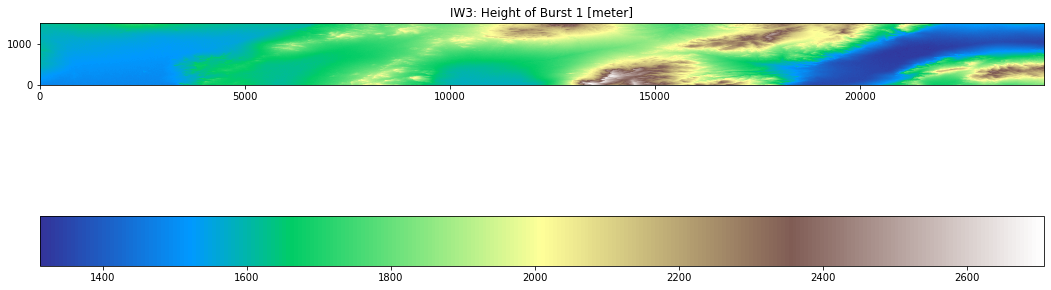

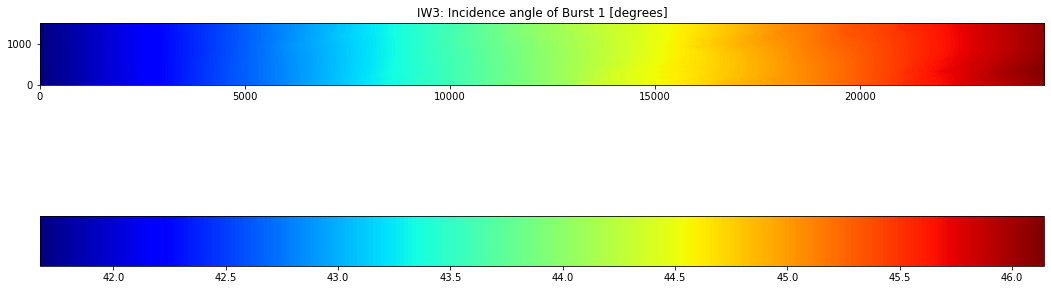

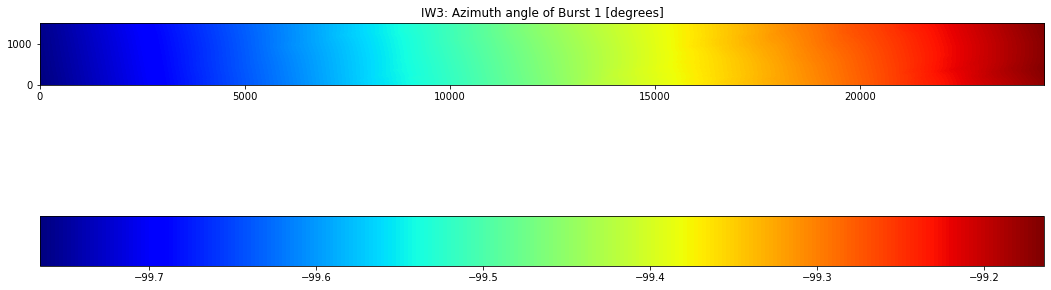

In [34]:
plotdata('geom_reference/IW3/hgt_01.rdr', band=1,
         title='IW3: Height of Burst 1 [meter]',
         colormap='terrain')
plotdata('geom_reference/IW3/los_01.rdr', band=1,
         title='IW3: Incidence angle of Burst 1 [degrees]',
         colormap='jet')
plotdata('geom_reference/IW3/los_01.rdr', band=2,
         title='IW3: Azimuth angle of Burst 1 [degrees]',
         colormap='jet')

### 3.4 Enhanced spectral diversity

In [ ]:
os.chdir(insar_dir)
!/opt/isce2/isce/applications/topsApp.py --start=subsetoverlaps --end=esd

#### 3.4.1 Step subsetoverlaps

Due to the large doppler frequency variation inherent to the TOPS acquisition mode, images supporting interferometry must be coregistered in the azimuth direction to better than 0.001 pixels, compared to regular stripmap data (0.1 of a pixel). While conventional cross-correlation of the amplitude works for the range direction, it does not provide sufficient accuracy for azimuth. The solution is to apply an Enhanced Spectral Diversity (ESD) approach to estimate the azimuth coregistration. In ESD processing, a double difference interferogram is made between the **reference** and **secondary** in the burst overlap region. As the range displacement is cancelled out, this interferogram will only show azimuthal motion. In absence of large ground deformation this azimuthal motion can be interpreted as an azimuthal coregistration offset. 

The following processing steps up to ESD are specific to burst overlap regions alone. 

By running the **subsetoverlaps** step, the top and bottom overlap between bursts is computed for the reference geometry. The information is then stored within the *overlaps* folder of the reference directory.  

Note, the nomenclature "top" and "bottom" can be confusing.  In this case, it is **not** referring to the top and bottom of the burst. It is referring to burst *n* as "top" and burst *n+1* as "bottom", visualizing it as the earlier image being laid on top of the later image, which is on the bottom. 

![title](support_docs/esd.png)
(Figure from Fattahi et. al., SCEC)

In [ ]:
# Uncomment to run this step only
!/opt/isce2/isce/applications/topsApp.py --dostep=subsetoverlaps

In [ ]:
!ls reference/overlaps/*

For each subswath being processed, you will find a *bottom_IW[].xml* and a *top_IW[].xml* file, associated with the overlap region in the the bottom and top overlapping bursts, respectively. Like before, only a IW3 folder is present for this tutorial. If you explore the file, you will find  additional information such as the FM rate and the doppler information.
```
    vim reference/overlaps/bottom_IW3.xml
```
Within the *overlaps* directory you will also find for each processed subswath a folder containing the cropped SLC's for each burst overlap region. The convention for top and bottom is as follows:
- Burst_bot_01_02.slc and Burst_top_01_02.slc both refer to the same burst overlap region, where:
    - Burst_bot_01_02.slc is the part of burst 2 (bot burst)
    - Burst_top_01_02.slc is the part of burst 1 (top burst)
- Burst_bot_02_03.slc and Burst_top_02_03.slc both refer to the same burst overlap region, where:
    - Burst_bot_02_03.slc is the part of burst 3
    - Burst_top_02_03.slc is the part of burst 2
- etc...

Though the overlap is not large, we will try to visualize the overlap by comparing:
- Burst_bot_01_02.slc and Burst_top_01_02.slc

Can you spot the overlap with respect to the full burst?

In [ ]:
plotcomplexdata('reference/overlaps/IW3/burst_bot_01_02.slc.vrt',
                title='bot_01_02 (from Burst 2)',
                aspect=10, datamin=0, datamax=200)
plotcomplexdata('reference/overlaps/IW3/burst_top_01_02.slc.vrt',
                title='top_01_02 (from Burst 1)',
                aspect=10, datamin=0, datamax=200)
plotcomplexdata('reference/IW3/burst_01.slc.vrt',
                title='Burst 1',
                aspect=10, datamin=0, datamax=200)
plotcomplexdata('reference/IW3/burst_02.slc.vrt',
                title='Burst 2', aspect=10,
                datamin=0,datamax=200,
                draw_colorbar=True,
                colorbar_orientation="horizontal")

#### 3.4.2 Step coarseoffsets

A coarse coregistration can be done using the orbits alone. This is also referred to as geometric coregistration. As ESD is applied in burst overlap region, there is no need to apply this **coarseoffsets** estimation step to the complete SLC. Instead, we estimate the coarse offset for each burst overlap as identified in the previous step.

In [ ]:
# Uncomment to run this step only
!/opt/isce2/isce/applications/topsApp.py --dostep=coarseoffsets

As output this generates a "*coarse_offsets/overlaps*" folder, within which is a subswath breakdown (*IW*) containing pixel-by-pixel azimuth offsets (*azimuth_[top,bot]_XX_YY.off*) and range offsets (*range_[top,bot]_XX_YY.off*) for each burst overlap.

In [ ]:
ls coarse_offsets/overlaps/IW3/*

Let us plot the average azimuth offset is for burst overlap: bot_01_02

In [ ]:
plotdata('coarse_offsets/overlaps/IW3/azimuth_bot_01_02.off.vrt', band=1,
         title='Azimuth bot_01_02', colormap='gray', aspect=10,
         nodata=-999999.)
!gdalinfo -stats coarse_offsets/overlaps/IW3/range_bot_01_02.off.vrt

Now do the same for the range offset.

In [ ]:
plotdata('coarse_offsets/overlaps/IW3/range_bot_01_02.off.vrt', band=1,
         title='Range bot_01_02', colormap='gray', aspect=10,
         nodata=-999999)
!gdalinfo -stats coarse_offsets/overlaps/IW3/range_bot_01_02.off.vrt


#### 3.4.3 Step coarseresamp

Both reference and secondary need to be in a common geometry prior to interferogram formation. In this step we will be taking the outputs from the coarse offset estimation and resample the secondary burst overlaps into the reference geometry.

In [ ]:
# Uncomment to run this step only
!/opt/isce2/isce/applications/topsApp.py --dostep=coarseresamp

The output of this step is stored in the "*coarse_coreg/overlaps/*" folder for each subswath. 

In [ ]:
ls coarse_coreg/overlaps/IW3/*

#### 3.4.4 Step overlapifg

Now that the reference and secondary burst overlap SLC's are in the same geometry we can compute the interferogram between the reference and the secondary. As there is a bottom and top set of SLC's, there will be two interferograms for each burst overlap: 
$$\Delta\Phi_{\text{bot}}  = \Phi_{\text{bot}}^{\text{ref}}*conj\left( \Phi_{\text{bot}}^{\text{sec}}\right) $$
$$\Delta\Phi_{\text{top}}  = \Phi_{\text{top}}^{\text{ref}}*conj\left( \Phi_{\text{top}}^{\text{sec}}\right) $$

In [ ]:
# Uncomment to run this step only
!/opt/isce2/isce/applications/topsApp.py --dostep=overlapifg

As output this generates a "*coarse_interferogram/overlaps*" folder, with in it a subswath breakdown (*IW*) containing the inteferograms (*burst_[top,bot]_XX_YY.int*) and multi-looked inteferograms (*burst_[top,bot]_XX_YY.7alks_19rlks.int*) for each burst overlap.

In [ ]:
ls coarse_interferogram/overlaps/IW3*

Let us plot all the multi-looked interferograms for the "top burst" overlaps together.

In [ ]:
plotstackcomplexdata('coarse_interferogram/overlaps/IW3/burst_top_*.3alks_7rlks.int',
                     title="Top overlaps ", aspect=10, datamin=0, datamax=6000,
                     draw_colorbar=True, colorbar_orientation="horizontal")

As you can see there is a large fringe-rate in the interferograms, especially towards the center of our study area. Do you have any thoughts why this might be?

#### 3.4.5 Step prepesd

Now that the bottom and top interferograms have been calculated the double difference interferogram can be calculated, this procedure is also referred to as spectral diversity: 
$$\Delta\Phi_{\text{ESD}} = \Delta\Phi_{\text{bot}}*conj\left(\Delta\Phi_{\text{top}}\right)$$

In [ ]:
#Uncomment to run this step only
!/opt/isce2/isce/applications/topsApp.py --dostep=prepesd

As output this generates a "*ESD*" folder, with in it the inteferograms (*overlap_[IW?]_XX.int*) and multi-looked interferograms (*overlap_[IW?]_XX.5alks_15rlks.int*) for each burst overlap *XX*.

#### 3.4.6 Step esd

The double difference interferogram only captures displacements in the azimuth direction. During the **esd** step, the phase of the double difference interferogram for each burst overlap is converted to pixel offsets using the azimuth frequency and difference of the Doppler Centroid frequency between the forward and backward-looking geometry. 

$$ \text{offset}_{\text{azimuth}}= \frac{f_{\text{azimuth}}}{2\pi} \frac{\text{arg}\left[e^{ j\Delta\Phi_{\text{ESD}}} \right]}{\Delta f_{\text{DC}}^{\text{overlap}}}$$

Once completed, all the offsets are combined together, and the mean of the distribution is taken as the azimuth coregistration offset. Note only those pixels with a coherence > than 0.85 are considered. 

<div class="alert alert-danger">
<b>POTENTIAL ISSUE:</b> 
Coherence is too bad to find reliable point to estimate the ESD threshold. Either take one the following two options listed below.
</div>
<br>
<div class="alert alert-warning">
<b>ESD threshold:</b> 
The ESD coherence threshold can be changed by the user in the **topsApp.xml** using the property **ESD coherence threshold"**. It is recommended not to go below 0.7. 
</div>
<br>
<div class="alert alert-warning">
<b>SKIP ESD:</b> 
In case you do not want to perform ESD, e.g. the coherence is to bad in the overlap regions, you could opt to skip ESD and only use the orbit information. This is controlled via **topsApp.xml** with the property **do ESD**. 
</div>

In [ ]:
# Uncomment to run this step only
!/opt/isce2/isce/applications/topsApp.py --dostep=esd

At the completion of the **esd** step you will see that *combined_*\**[.cor,.int,freq.bin]* files as well as an *ESDmisregistration.jpg* figure have been added to the "*ESD*" folder.

In [ ]:
ls ESD/combined* ESD/ESDmisregistration*

The combined coherence and interferogram files are used as input to the ESD azimuth offset estimation:

In [ ]:
# Plot ESD coherence
plotdata('ESD/combined_IW3.cor', band=1,
         title="coherence [-]", aspect=10,
         datamin=0, datamax=1, background='yes')

# Plot double difference interferogram
plotcomplexdata('ESD/combined_IW3.int',
                title="Diff IFG [-]", aspect=10,
                datamin=100000, datamax=100000000,
                draw_colorbar=True)

In general, high coherence can be observed (> 0.85), and thus most pixels will be used in the ESD histogram generation. The interferogram shows strong azimuthal motion at the location of the earthquake. Away from the earthquake the impact is less, showing on average ~0 rad of azimuthal phase. Let us investigate if this potentially has biased the ESD estimation by inspecting the historgram figure that was created as part of the **esd** step:

In [ ]:
import matplotlib.image as mpimg
img= mpimg.imread("ESD/ESDmisregistration.png")
fig = plt.figure(figsize=(10, 11))
plt.imshow(img);

<div class="alert alert-warning">
<b>TIP:</b> 
It is always good to inspect the inputs of the ESD calculation, as there are sources such as ionosphere and tectonic deformation that can cause an apparent azimuthal shift, potentially biasing the mean of the ESD estimation.
</div>

### 3.5 Step rangecoreg

In the next step we will estimate the offset in the range direction by doing an amplitude cross-correlation between the reference and secondary burst overlaps. As for the azimuth offsets, a histogram of the range offset is used to estimate the mean range offset for the complete SLC. Note only pixels with an SNR of 8 or above are considered.

In [ ]:
os.chdir(insar_dir)
!/opt/isce2/isce/applications/topsApp.py --dostep=rangecoreg

Let us vizualize the results:

In [ ]:
ls ESD

In [ ]:
import matplotlib.image as mpimg
img= mpimg.imread("ESD/rangeMisregistration.jpg")
fig = plt.figure(figsize=(10, 11))
plt.imshow(img);

### 3.6 Coregistered bursts

In [ ]:
os.chdir(insar_dir)
!/opt/isce2/isce/applications/topsApp.py --start=fineoffsets --end=fineresamp

#### 3.6.1 Step fineoffsets

Now that we have estimated the range and azimuth offsets using the burst overlap regions, we will apply them to the full bursts in the **fineoffsets** step. 

In [ ]:
# Uncomment to run only this step
!/opt/isce2/isce/applications/topsApp.py --dostep=fineoffsets

The output is stored in the *fine_offsets* folder for each subswath, with an azimuth offset file (*azimuth_XX.off*) and a range offset file (*range_XX.off*) for each burst *XX*.

In [ ]:
ls fine_offsets/*

#### 3.6.2 Step fineresamp

The burst fine offset files just created are used to resample the secondary burst SLC's into the reference geometry using the **fineresamp** step.

In [ ]:
#Uncomment to run this step only
!/opt/isce2/isce/applications/topsApp.py --dostep=fineresamp

The output is stored in the *coreg_fine* folder for each subswath, containing the resampled secondary burst SLC's (*burst_XX.slc*).

### 3.7 Ionospheric phase screen

In this tutorial, we are going to skip this step. We encourage students to read up on this step and setup appropriate parameters in **topsApp.xml** to exercise this option. By default, no ionosphere correction is performed. So this step is a pass through for this exercise.

In [ ]:
os.chdir(insar_dir)
!/opt/isce2/isce/applications/topsApp.py --dostep=ion

### 3.8 Interferogram generation

In [ ]:
os.chdir(insar_dir)
!/opt/isce2/isce/applications/topsApp.py --start=burstifg --end=filter

#### 3.8.1 Step burstifg

The secondary and reference burst SLC's are now in a common geometry, and interferograms can be computed for each burst. We will do this as part of the **burstifg** step.

In [ ]:
#Uncomment to run this step only
!/opt/isce2/isce/applications/topsApp.py --dostep=burstifg

This step generates a "*fine_interferogram*" folder, within which is a subswath breakdown (*IW*), each containing their respective interferograms (*burst_XX.int*), the coherence (*burst_XX.cor*), and the multilooked interferograms (*burst_XX.3alks_7rlks.int*) for each burst *XX*.

In [ ]:
ls fine_interferogram/*

Here is a plot of one of the burst interferograms:

In [ ]:
plotcomplexdata('fine_interferogram/IW3/burst_03.3alks_7rlks.int.vrt', 
                title="Burst 3 IFG ", aspect=3, datamin=0, datamax=10000,
                draw_colorbar=True)

#### 3.8.2 Step mergebursts

As you can tell from the figure, it is hard to capture the full extent of the earthquake deformation from a single burst. In the **mergebursts** step, we will combine the different bursts together to generate a combined product.

In [ ]:
#Uncomment to run this step only
!/opt/isce2/isce/applications/topsApp.py --dostep=mergebursts

The output is written into the "*merged*" folder. This folder contains the merged interferogram (**topophase.flat**), the coherence (**topophase.cor**), the line-of-sight (LOS) angles (**los.rdr**), the heights (**z.rdr**), the longitude (**lon.rdr**), and the latitude information (**lat.rdr**). These files are multilooked, while files with a *.full* suffix refer to the full resolution data. You can also find a merged SLC for the reference (**reference.slc.full.vrt**) and the secondary (**reference.slc.full.vrt**). These files are generated if **do denseoffsets** property is set to *True* in **topsApp.xml**. You can use *gdalinfo* to explore the format of these files and the number of bands.


Here is a plot of the merged intergerogram:

In [ ]:
plotcomplexdata('merged/topophase.flat.vrt', 
                title="MERGED IFG ", aspect=3,
                datamin=0, datamax=10000, draw_colorbar=True)

In this particular example, there appears to be no obvious discontinuities in the earthquake region across bursts. With other earthquakes, we often observe slight misalignment of bursts close to the rupture. This is likely introduced by either the ionosphere or leakage of the earthquake azimuth deformation into the ESD estimation procedure. Two potential avenues can be further explored:

1. In addition to the ESD threshold, mask out pixels within the earthquake region. i.e. let the ESD estimation be described by the far-field.
2. Specify not to use ESD in the topsApp.xml. Instead only use the orbit information for coregistration purposes.

#### 3.8.3 Step filter

Multilooking reduces noise, but it is often insufficient for interpreting the interferogram or unwrapping. We often apply additional filtering to improve the SNR.

In [ ]:
# Uncomment to run this step only
!/opt/isce2/isce/applications/topsApp.py --dostep=filter

The outputs of the filtering step are added to the merged folder, where the filtered interferogram is called **filt_topophase.flat**, and the filtered coherence **phsig.cor**. Note that the latter is different from conventional coherence: it is based on an estimate of the standard deviation of the phase translated back to coherence through the Cramer-Rao bound relationship:

$\gamma = \frac{1}{\sqrt{1+2N\sigma_\phi^2}}$

Let us compare the filtered and unfiltered interferograms:

In [ ]:
plotcomplexdata('merged/topophase.flat.vrt',
                title="MERGED IFG ", aspect=3,
                datamin=0, datamax=10000, draw_colorbar=True)
plotcomplexdata('merged/filt_topophase.flat.vrt', 
                title="MERGED FILT IFG ", aspect=1,
                datamin=0, datamax=10000, draw_colorbar=True)

<div class="alert alert-warning">
<b>FILTER STRENGTH:</b> 
The amount of filtering can be controlled through the **"filter strength"** property in the **topsApp.xml file**.</div>
<div class="alert alert-danger">
<b>POTENTIAL ISSUE:</b> 
As a user you can change the filtering strength. Care should be taken, as a smoother and cleaner interferogram does not necessarily imply a better interferogram. Always inspect the interferogram before and after filtering and assess if false signals are introduced or if dense fringes are oversmoothed due to overfiltering. Look carefully at noisy regions, where fringes from coherent areas "bleed" into noisy areas.
</div>


### 3.9 Phase unwrapping

In [ ]:
os.chdir(insar_dir)
!/opt/isce2/isce/applications/topsApp.py --start=unwrap --end=unwrap2stage

#### 3.9.1 Step unwrap

In the next step we will use **snaphu** to unwrap the interferogram:

In [ ]:
#Uncomment to run this step only
!/opt/isce2/isce/applications/topsApp.py --dostep=unwrap

The unwrapped output is added to the "*merged*" folder. The unwrapped interferogram is contained in **filt_topophase.unw**. You will also find the connected components stored in **filt_topophase.conncomp**. We plot them below and inspect the results for potential errors.

<div class="alert alert-warning">
<b>INSPECT CONNECTED COMPONENT OUPUT:</b> 
The connected component file is a metric of the unwrapping performance. It provides information on which parts of the unwrapped image are connected. Regions with a different connected component can have a phase jump equivalent to a multiple of 2 $\pi$. It is therefore important to always inspect both the phase and the connected component output together. </div>

<div class="alert alert-warning">
<b>CONNECTED COMPONENT NUMBERS:</b> 
Connected component 0 refers to those pixels which cannot be reliably unwrapped. These should be masked out before doing any sort of modeling. The other connected components increment by 1 per isolated region.
</div>
<div class="alert alert-danger">
<b>UNWRAPPING ERROR EXAMPLE:</b> 
To see unwrapped result with non-physical phase jumps, run the "icu" unwrapper by changing the **unwrapper name** property in **topsApp.xml** to *icu*. Note that the filename for the icu connected component is **filt_topophase.conncomp**.
</div>


In [ ]:
plotdata('merged/filt_topophase.unw', band=2,
         title="UNW FILT IFG [rad] ",
         colormap='jet', colorbar_orientation="vertical")

plotdata('merged/filt_topophase.unw.conncomp', band=1,
         title="UNW CONN COMP [-] ", colormap='jet',
         colorbar_orientation="vertical",
         nodata=0)

#### 3.9.2 Step unwrap2stage

There is also a two-stage unwrapper where the outputs of the connected component file are used to adjust the unwrapped interferogram. During this optimization procedure, the phase offset between connected component boundaries are minimized. This step can only be run if the unwrapping was done with the  *snaphu_mcf* unwrapper, and also requires the **"do unwrap2stage"** property to be set to *True*. Both are controlled in the topsApp.xml. 

We did not enable the two stage unwrapper. The impact should be small given only small scale connected components.  Executing the **unwrap2stage** will therefore complete instantly.

In [ ]:
#Uncomment to run this step only
!/opt/isce2/isce/applications/topsApp.py --dostep=unwrap2stage

### 3.10 Step geocode

In the next step we will **geocode** many of the output products created to this point. By default topsApp.py geocodes the following files: **filt_topophase.flat**, **filt_topophase.unw**, **los.rdr**, **phsig.cor**, **topophase.cor** and **topophase.flat**. The user can control which files are geocoded using the **"geocode list"** property in **topsApp.xml**.

In [ ]:
os.chdir(insar_dir)
!/opt/isce2/isce/applications/topsApp.py --dostep=geocode

In [ ]:
plotdata('merged/filt_topophase.unw.geo', band=2,
         title="UNW GEO FILT IFG [rad] ", colormap='jet',
         colorbar_orientation="vertical", datamin=-20, datamax=50)
#plotdata('merged/filt_topophase_2stage.unw.geo',2,title="UNW 2-stage GEO FILT IFG [rad] ",colormap='jet',colorbar_orientation="vertical",datamin=-40, datamax=200)

#### 3.10.1 Changing your geocode DEM or using your own DEM

To experiment with a coarser resolution DEM, proceed with this section. By default, the geocoding in topsApp.py is done at the same sampling as processing DEM. However, a different DEM can be specified using the **geocode demfilename** property. 

##### Option 1: Downsample your processing DEM

The ISCE contrib folder has a script called **downsampleDEM.py** that allows you to downsample a DEM to a user-defined sampling. To see how to call the function type: 

In [ ]:
!downsampleDEM.py -h

Let us now locally downsample this dem to 120m using **downsampleDEM.py**

In [ ]:
!downsampleDEM.py -i demLat_N37_N39_Lon_W119_W117.dem.wgs84.vrt -rmeter 120

In [ ]:
!ls Coarse*.wgs84*

Now update your **geocode demfilename** in the topsApp.xml file with the new coarse DEM. Once done, you can run the geocode step again:

In [ ]:
!/opt/isce2/isce/applications/topsApp.py --dostep=geocode
plotdata('merged/filt_topophase.unw.geo', band=2,
         title="UNW GEO FILT IFG [rad] ",
         colormap='jet',colorbar_orientation="vertical")

##### Option 2: Use of a different DEM (User exercise)

DEMs are often available in different formats. The checklist for bringing your own DEM for processing the data is as follows:

1. Map projection: ISCE currently supports only EPSG:4326 / EPSG:4979 projection systems - i.e lat/lon on a WGS84 Ellipsoid. If your DEM is in another system like Polar Stereographic or UTM- you will need to reproject it to lat/lon using gdalwarp or your favorite tools.

2. File format: ISCE currently supports flat binary rasters only. If your DEM is in a geotiff / GMTs grd format you will need to convert it to flat binary format. We recommend using gdal_translate to convert it to a ENVI file format.

3. Generate the XML and VRT file to go with the flat binary. This can be done with gdal2isce_xml.py. Using this script with an ENVI format file will generate the right ISCE XML and VRT files.


4. If DEM is in another folder and you want to use it for processing, use fixImageXml.py to set the paths in the xml file to use absolute paths. 


5. Vertical datum: The data should in the DEM represent Ellipsoid heights (.dem.wgs84) / heights above EGM96 (.dem). The vertical reference is communicated to ISCE by setting the reference tag to EGM96 / WGS84
```xml
<property name="reference">
    <value>EGM96</value>
    <doc>Geodetic datum</doc>
</property>
```
Make sure that the correct tag is present in your DEM xml file. Add this field, if it is missing. 

In [ ]:
# Utility to generate XML and VRT from ENVI format flat binary files
!gdal2isce_xml.py -h

In [ ]:
# Utility to fix paths in ISCE XML files
!fixImageXml.py -h

From the help, you can see that the **-f** option will update the path in the xml file with an absolute path. Now run the command:

Once, you have your DEM prepared update the "demfilename" or "geocode demfilename" as needed for processing your data.

### 3.11 Pixel offset maps (User exercise)

In addition to the interferogram, topsApp.py can also be used to generate pixel offset maps. By default, pixel offsets are turned off. You can enable this by uncommenting the "do denseoffsets" line in our topsApp.xml

In [ ]:
!/opt/isce2/isce/applications/topsApp.py --start=denseoffsets --end=geocodeoffsets

#### 3.11.1 Step denseoffsets

In addition to the interferometric processing, we also requested to run the **denseoffsets** step in the **topsApp.xml**. The azimuth and range offsets are estimated by doing a cross-correlation between the coregistered reference and secondary SLC's on a dense grid, providing a low resolution image of displacement in the range and azimuth domain.

In [ ]:
#Uncomment to run this step only
!/opt/isce2/isce/applications/topsApp.py --dostep=denseoffsets

The output file, **dense_offsets.bil**, is a two-band file containing the azimuth and range offsets, placed in the "*merged*" folder . The correlation coefficient is contained in the **dense_offsets_snr.bil** file.

Here is a plot of the azimuth and range offsets:

In [ ]:
# This will only work if you enabled pixel offset generation
plotdata('merged/dense_offsets.bil', band=2,
         title="DENSE RANGE OFFSETS [pixels] ",
         datamin=-0.5, datamax=0.5,
         colormap='jet', colorbar_orientation="vertical")

plotdata('merged/dense_offsets.bil',band=1,
         title="DENSE AZIMUTH OFFSETS [pixels] ",
         datamin=-0.25, datamax=0.25
         colormap='jet', colorbar_orientation="vertical")

#### 3.11.2 Step filteroffsets

The denseoffsets can be a bit noisy. In the following step, we will clean this up by applying a filter. The output will be added to the "*merged*" folder under the filename **filt_dense_offsets.bil**.

In [ ]:
#Uncomment to run this step only
!/opt/isce2/isce/applications/topsApp.py --dostep=filteroffsets

#### 3.11.3 Step geocodeoffsets

Geocoding the filtered dense offsets generates a **filt_dense_offsets.bil.geo** file in the "*merged*" folder.

In [ ]:
#Uncomment to run this step only
!/opt/isce2/isce/applications/topsApp.py --dostep=geocodeoffsets

Here is a plot of the final geocoded filtered dense offsets:

In [ ]:
# This will only work if you enabled pixel offset generation
plotdata('merged/filt_dense_offsets.bil.geo', band=2,
         title="DENSE AZIMUTH OFFSETS [pixels] ",
         datamin=-0.5, datamax=0.5,
         colormap='jet', colorbar_orientation="vertical")
plotdata('merged/filt_dense_offsets.bil.geo',band=1,
         title="DENSE RANGE OFFSETS [pixels] ",
         datamin=-0.25, datamax=0.25,
         colormap='jet', colorbar_orientation="vertical")

### 4. Recommended user exercises

We recommend the following exercises for users to get used to the different options available with topsApp.py. These exercises involve reading the detailed topsApp.xml file included in the examples and set appropriate properties and rerun topsApp.py workflows.

#### 4.1 Process complete Sentinel-1 frames

In this exercise, we demonstrate use of topsApp.py to process a small region of interest. Users can remove this subsetting option and process all 3 swaths in one go.

#### 4.2 Process multiple Sentinel-2 frames together

In this exercise, we used a single SLC each acquired on the reference and secondary dates. Users can add multiple SLCs for each of the dates and let topsApp.py mosaic them together for you.

#### 4.3 Ionospheric phase screen

As mentioned in Section 3.7, we skipped ionospheric phase screen generation in this exercise. We recommend users get familiar with various flags and options available in topsApp.py to control the generation of ionospheric phase screens [see, bottom of page here](https://github.com/isce-framework/isce2/blob/main/examples/input_files/topsApp.xml). Users only need to start from "step ion" for this exercise.

#### 4.4 Generate pixel offsets without generating interferogram

If you are interested in pixel offset maps over fast moving ice streams/ glaciers and not interested in wasting time on interferogram generation which are likely to be decorrelated, you can figure out the correct options to set in topsApp.xml to generate pixel offsets only.

#### 4.5 Familiarize yourself with interferogram post processing

By default, the interferograms are filtered before unwrapping. We recommend users get familiar with impact of different filter strengths on their datasets. topsApp.py also offers multiple unwrapping options like - icu, snaphu, snaphu_mcf and grass. Exercising these options over different decorrelation regimes will let users become familiar with the strengths and weaknesses of each of the methods. Users only need to rerun steps starting from filtering for this exercise.

#### 4.6 Familiarize yourself with impact of ESD

topsApp.py includes optimizations to generate "ESD" corrections using only the overlaps between bursts. However, users can turn off this refinement if they chose to - depending on their application. Users only need to start from steps related to ESD for this exercise.

# Relevant references:
- Heresh Fattahi, Piyush Agram, and Mark Simons, *Precise coregistration of Sentinel-1A TOPS data*, https://files.scec.org/s3fs-public/0129_1400_1530_Fattahi.pdf
- Fattahi, H., Agram, P. and Simons, M., 2016. A network-based enhanced spectral diversity approach for TOPS time-series analysis. IEEE Transactions on Geoscience and Remote Sensing, 55(2), pp.777-786. https://core.ac.uk/reader/77927508
- ESA, *Sentinel-1 and TOPS overview*, https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar
- Nestor Yague-Martinez, Pau Prats-Iraola, Fernando Rodriguez Gonzalez,Ramon Brcic, Robert Shau, Dirk Geudtner, Michael Eineder, and Richard Bamler, *Interferometric Processing of Sentinel-1 TOPS Data*, IEEE, doi:10.1109/TGRS.2015.2497902, https://ieeexplore.ieee.org/document/7390052/
- Liang, C., Agram, P., Simons, M. and Fielding, E.J., 2019. Ionospheric correction of insar time series analysis of c-band sentinel-1 tops data. IEEE Transactions on Geoscience and Remote Sensing, 57(9), pp.6755-6773. 